In [3]:
#libraries
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

In [4]:
#loading csv file from directory
df = pd.read_csv("/content/mv_test.csv")
#Adding a column for the mean between score1 and score2
df["mean"] = df[["score1","score2"]].mean(axis=1)
df = df.drop(['Unnamed: 4', 'Unnamed: 5'], axis=1)
df

,ID,bad,score1,score2,mean
0,A00000052226,1,428,584,506.0
1,A00000050031,1,435,689,562.0
2,A00000057573,1,437,644,540.5
3,A00000033767,1,438,645,541.5
4,A00000021091,1,439,638,538.5
...,...,...,...,...,...
70984,A00000045477,0,862,912,887.0
70985,A00000031849,0,862,921,891.5
70986,A00000024835,0,862,922,892.0
70987,A00000031397,0,862,923,892.5


Question 1

In [5]:
#Calculating mean and standard deviation for bad and good scores
mu_good, sigma_good = df.loc[df['bad'] == 0, 'score1'].mean(), df.loc[df['bad'] == 0, 'mean'].std()
mu_bad, sigma_bad = df.loc[df['bad'] == 1, 'mean'].mean(), df.loc[df['bad'] == 1, 'mean'].std()
print(mu_good, mu_bad, sigma_good, sigma_bad)

741.6265406897625 643.1171295585904 78.48573168268081 52.99733877086087


In [6]:
#Creating small function to calculating divergence score
def divergence(*args):
  return 2*(mu_good - mu_bad)**2/(sigma_good**2 + sigma_bad**2)

In [7]:
divergence(mu_good, sigma_good, mu_bad, sigma_bad)

2.1639867074343764

Question 2

In [8]:
#Creating a list which creates bins 0-500, 500-520 520-540, ...,780-800, 800-inf
my_list = []
my_list.append(0)
for i in range(500, 820, 20):
  my_list.append(i)
my_list.append(np.inf)

In [9]:
df_new = pd.DataFrame({'Total # (S1)': df["score1"],
                       'Bads # (S1)': df["bad"],
                   'Total # (S2)': df["score2"],
                   'Bads # (S2)': df["bad"],})

# apply lambda function to count binary variables of score 1
result = df_new.groupby(pd.cut(df_new['Total # (S1)'], my_list, right=False)).apply(lambda x: pd.Series({
    'Total # (S1)': x['Total # (S1)'].count(),
    'Bads # (S1)': x['Bads # (S1)'].astype(bool).sum(),
}))

# apply lambda function to count binary variables of score 2
result2 = df_new.groupby(pd.cut(df_new['Total # (S2)'], my_list, right=False)).apply(lambda x: pd.Series({
    'Total # (S2)': x['Total # (S2)'].count(),
    'Bads # (S2)': x['Bads # (S2)'].astype(bool).sum(),
}))

# concatenate the dataframes horizontally
df_concat = pd.concat([result, result2], axis=1)

# reset the index
df_concat = df_concat.reset_index()

# rename the columns
df_concat.columns = ['Score Band', 'Total # (S1)', 'Bads # (S1)', 'Total # (S2)', 'Bads # (S2)']

#Reshaping columns and adding bad rate for each score
df_concat.set_index("Score Band", inplace=True)
df_concat['Bad Rate (S1)'], df_concat['Bad Rate (S2)'] = df_concat['Bads # (S1)'] / df_concat['Total # (S1)'], df_concat['Bads # (S2)'] / df_concat['Total # (S2)']
bad1_col = df_concat.pop('Bad Rate (S1)')
df_concat.insert(2, 'Bad Rate (S1)', bad1_col)
df_concat.fillna(pd.to_numeric(0, downcast='integer'), inplace=True)
df = df_concat

In [10]:
#Using multi index from tuples to have a header along with multiple subheaders
columns = pd.MultiIndex.from_tuples([('Score 1', 'Total #'), ('Score 1', 'Bad #'), ('Score 1', 'Bad Rate'), ('Score 2', 'Total #'), ('Score 2', 'Bad #'), ('Score 2', 'Bad Rate'),])
df.columns = columns
print(df)
print("\n")



               Score 1                 Score 2                
               Total # Bad #  Bad Rate Total # Bad #  Bad Rate
Score Band                                                    
[0.0, 500.0)       178   156  0.876404       0     0  0.000000
[500.0, 520.0)     331   286  0.864048       0     0  0.000000
[520.0, 540.0)     713   580  0.813464       0     0  0.000000
[540.0, 560.0)    1232   968  0.785714     293   198  0.675768
[560.0, 580.0)    1936  1417  0.731921    1966  1241  0.631231
[580.0, 600.0)    2842  1946  0.684729    4553  2699  0.592796
[600.0, 620.0)    3875  2321  0.598968    6388  3416  0.534753
[620.0, 640.0)    4677  2470  0.528116    6912  3093  0.447483
[640.0, 660.0)    5401  2415  0.447139    6419  2395  0.373111
[660.0, 680.0)    5678  2208  0.388869    5969  1861  0.311778
[680.0, 700.0)    5215  1585  0.303931    5200  1388  0.266923
[700.0, 720.0)    5080  1138  0.224016    4448   990  0.222572
[720.0, 740.0)    4760   775  0.162815    3622   615  0

Question 3

In [11]:
#Changing pandas series to float to calculate the log odds of Score 1 and Score 2
question3_df_float = df_concat.astype(float)

#Droping the top headers and renaming columns for simplicity
question3_df_float.columns = question3_df_float.columns.droplevel()
question3_df_float.columns.values[[3, 4, 5]] = ['Total # S2', 'Bad # S2', 'Bad Rate S2']
question3_df_float

#Making the odds columns then taking the log of each column, log() without specifying a base refers to the base-10 logarithm
question3_df_float["log_odds_s1"], question3_df_float["log_odds_s2"] = (question3_df_float["Total #"] - question3_df_float["Bad #"] / question3_df_float["Total #"]), (question3_df_float["Total # S2"] - question3_df_float["Bad # S2"] / question3_df_float["Total # S2"])
question3_df_float["log_odds_s1"], question3_df_float["log_odds_s2"] = question3_df_float["log_odds_s1"].apply(lambda x: math.log(x, 10)), question3_df_float["log_odds_s2"].apply(lambda x: math.log(x, 10))
question3_df_float.fillna(0, inplace=True)
question3_df_float

,Total #,Bad #,Bad Rate,Total # S2,Bad # S2,Bad Rate S2,log_odds_s1,log_odds_s2
Score Band,,,,,,,,
"[0.0, 500.0)",178.0,156.0,0.876404,0.0,0.0,0.000000,2.248276,0.000000
"[500.0, 520.0)",331.0,286.0,0.864048,0.0,0.0,0.000000,2.518693,0.000000
"[520.0, 540.0)",713.0,580.0,0.813464,0.0,0.0,0.000000,2.852594,0.000000
"[540.0, 560.0)",1232.0,968.0,0.785714,293.0,198.0,0.675768,3.090334,2.465865
"[560.0, 580.0)",1936.0,1417.0,0.731921,1966.0,1241.0,0.631231,3.286741,3.293444
"[580.0, 600.0)",2842.0,1946.0,0.684729,4553.0,2699.0,0.592796,3.453519,3.658241
"[600.0, 620.0)",3875.0,2321.0,0.598968,6388.0,3416.0,0.534753,3.588205,3.805329
"[620.0, 640.0)",4677.0,2470.0,0.528116,6912.0,3093.0,0.447483,3.669918,3.839576
"[640.0, 660.0)",5401.0,2415.0,0.447139,6419.0,2395.0,0.373111,3.732438,3.807442


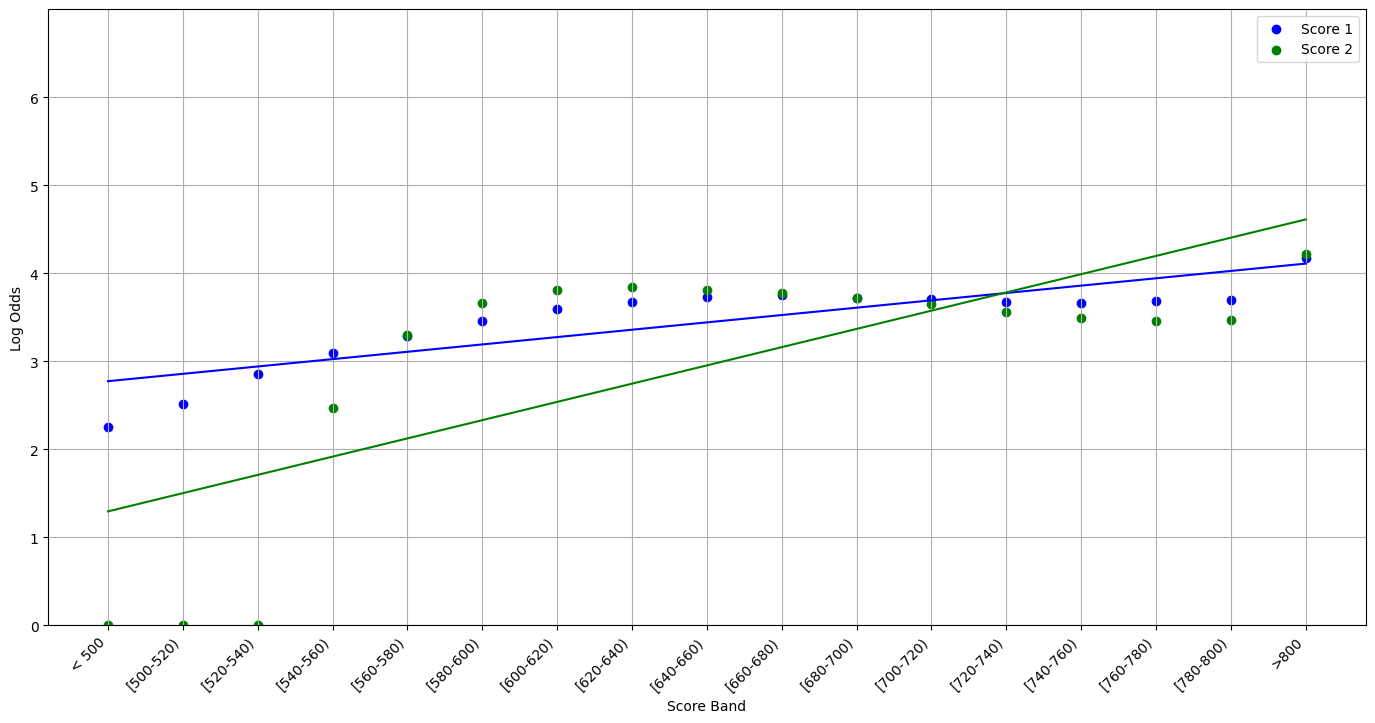

In [19]:
x = question3_df_float.index.codes.astype(float)
y1 = question3_df_float['log_odds_s1']
y2 = question3_df_float['log_odds_s2']


# Calculate the coefficients for the lines of best fit for each set of data
coeffs1 = np.polyfit(x, y1, 1)
coeffs2 = np.polyfit(x, y2, 1)

# Create functions for each line of best fit based on the calculated coefficients
line1 = np.poly1d(coeffs1)
line2 = np.poly1d(coeffs2)

#finding b0 and b1 from np polyfit
b1_line1, b0_line1 = line1.coef
b1_line2, b0_line2 = line2.coef

# Plot the scatter points for both sets of data
plt.scatter(x, y1, label='Score 1', color="blue")
plt.scatter(x, y2, label='Score 2', color="green")

# Plot each line of best fit
plt.plot(x, line1(x), color="blue")
plt.plot(x, line2(x), color="green")

#Creating string list of the score bands along with their positions on x-axis
string_list = [f"<{i}" if i<500 else f"{i}-{i+20}" if i<800 else f">{i}" for i in range(500, 820, 20)]
string_list.insert(0, "< 500")
#Adding [ ) to the x ticks 
for i in range(len(string_list)):
    if i != 0 and i != len(string_list) - 1:
        string_list[i] = "[" + string_list[i] + ")"
number_list = [i for i in range(0, 17)]

# Add a legend and labels for the axes
plt.legend()
plt.xlabel('Score Band')
plt.ylabel('Log Odds')
plt.ylim(0, 7)
plt.yticks(range(0, 7))
plt.xticks(number_list, string_list, rotation=45, ha='right')
plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(17,8)

# Show the plot
plt.show()


In [13]:
#Getting various stats of each score
def get_stats(independent, dependent, score): 
  slope, intercept, r_value, p_value, std_err = stats.linregress(independent, dependent)
  print("\033[4m" + score + "\033[0m")
  print("Slope:", slope)
  print("Intercept:", intercept)
  print("R-squared:", r_value**2)
  print("P-value:", p_value)
  print("std err:", std_err)
  print("\n")

get_stats(x, y1, "Score 1")
get_stats(x, y2, "Score 2")

Score 1
Slope: 0.08351574891369841
Intercept: 2.7730896679818153
R-squared: 0.7249478287721699
P-value: 1.4550038196221625e-05
std err: 0.013282410935317865


Score 2
Slope: 0.20734936312996757
Intercept: 1.293576959825877
R-squared: 0.5196875729617704
P-value: 0.0010938151032315621
std err: 0.051469247875471275




In [14]:
#Getting rmse and mse of each score while creating predicted arrays comparing with true arrays for these computations
y1_new = line1(np.array(y1))
y2_new = line2(np.array(y2))

def get_rmse(true, pred, score):
  print("\033[4m" + score + "\033[0m")
  mse = mean_squared_error(true, pred)
  print("MSE: ", mse)
  rmse = np.sqrt(mse)
  print("RMSE: ", rmse)
  print("\n")


get_rmse(y1, y1_new, "Score 1")
get_rmse(y2, y2_new, "Score 2")

Score 1
MSE:  0.33890621207883564
RMSE:  0.5821565185401909


Score 2
MSE:  2.3429111250154455
RMSE:  1.5306570892970919




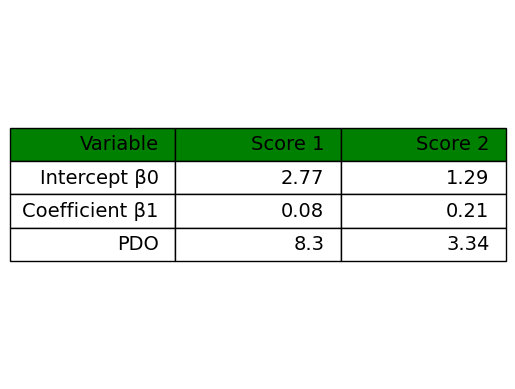

In [15]:
#organizing data for table, calculate PDO which is the natural logarithm of base 2 / beta 1's for each score 
table_data = [['Variable', 'Score 1', 'Score 2'],
        ['Intercept β0', round(b0_line1, 2), round(b0_line2, 2)],
        ['Coefficient β1', round(b1_line1, 2), round(b1_line2, 2)],
        ['PDO', round(math.log(2)/b1_line1, 2), round(math.log(2)/b1_line2, 2)]]

# set the colors for the table
colors = [['green'] * 3]  # set top row to light gray
for i in range(1, len(table_data)):
    colors.append(['w'] * 3)  # set all other rows to white

# create the table plot
fig, ax = plt.subplots()
ax.axis('off')  # remove axes

# plot the table using table function
table = ax.table(cellText=table_data, cellColours=colors, loc='center')

# set table properties
table.set_fontsize(14)
table.scale(1, 2)  # set table size

# display the plot
plt.show()



Question 4

In [16]:
#Rename for ease of use for this function
x = question3_df_float.index.codes.astype(float)
y1 = question3_df_float['log_odds_s1']
y2 = question3_df_float['log_odds_s2']

#create function which prints beta 0 and beta 1 for each score
def calculate_betas(x, y, score):
  X_mean = sum(x) / len(x)
  Y_mean = sum(y) / len(y)

  dev_X = [i - X_mean for i in x]
  dev_Y = [j - Y_mean for j in y]

  SS_xy = sum([dev_X[i] * dev_Y[i] for i in range(len(x))])
  SS_xx = sum([(j - X_mean)**2 for j in x])

  beta1 = SS_xy / SS_xx
  beta0 = Y_mean - beta1 * X_mean

  print("\033[4m" + score + "\033[0m", ": β0 =", round(beta0, 2), "and β1 =", round(beta1, 2))
  print("\n")

calculate_betas(x, y1, "Score 1")
calculate_betas(x, y2, "Score 2")


Score 1 : β0 = 2.77 and β1 = 0.08


Score 2 : β0 = 1.29 and β1 = 0.21




Question 5

Based on the questions above, I believe the divergence measure indicates how well-separated the two groups are based on their means and variances. A larger divergence value indicates that the two groups are more distinct and easier to separate, while a smaller value indicates that the two groups are more similar and harder to separate. It's worth noting that the divergence measure is just one of many possible measures of separation between two groups. Other measures, such as Cohen's d score is a standardized effect size measure that compares the means of two sets of variables. It expresses the difference between the means in terms of standard deviations, which makes it easier to compare effect sizes across different studies. Additionally, we could look at The Mahalanobis distance, which is a measure of the distance between two sets of variables that considers the correlation between the variables. It is useful when the variables are highly correlated and the differences between the sets of variables are complex.

Moreover, I believe PDO value indicates the time it takes for a value to decrease by half. As the formula for PDO equals (ln(2) / beta 1), in this particular case, the PDO value indicates the time it takes for the value of beta1 to decrease to half. Some precautions which must be realised when using the PDO value is that it's dependent on the growth conditions of the data. Changes in these conditions can significantly affect the growth rate and PDO value, making it difficult to compare results from different experiments. Additional tests that could be implemented when looking for the half-life in a decay process include, Exponential regression which can be used to model the decay process and estimate the rate of decay, The chi-squared test which can be used to test whether the observed data fits an exponential decay model, Maximum likelihood estimation which can be used to estimate the parameters of an exponential decay model, and finally Nonlinear regression which can be used to fit an exponential decay model to the data and estimate the half-life.
